# DRL Initial Training

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import yfinance as yf
import random
import os

In [18]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA or CPU: ", device)
print("Device: ",torch.cuda.get_device_name(0))

CUDA or CPU:  cuda
Device:  NVIDIA GeForce RTX 4080


In [19]:
# Experiment parameters
WINDOW_SIZE = 120  # Rolling window size for state representation
STD_WINDOW_SIZE = 20
NUM_ASSETS = 14   # Example number of assets
ENV_STEP_SIZE = 1
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-4
DISCOUNT_FACTOR = 0.9
BATCH_SIZE = 50
EPISODES = 250
THETA = 0.5
SIGMA = 0.02
LAMBDA = 2

In [20]:
# Parameters
start_analysis_date = "2010-01-01"

# Define tickers
tickers = {
    'XLF': 'XLF',   # Financials Select Sector SPDR Fund
    'XLK': 'XLK',   # Technology Select Sector SPDR Fund
    'XLE': 'XLE',   # Energy Select Sector SPDR Fund
    'XLP': 'XLP',   # Consumer Staples Select Sector SPDR Fund
    'XLY': 'XLY',   # Consumer Discretionary Select Sector SPDR Fund
    'XLU': 'XLU',   # Utilities Select Sector SPDR Fund
    'XLI': 'XLI',   # Industrials Select Sector SPDR Fund
    'XLV': 'XLV',   # Health Care Select Sector SPDR Fund
    'VNQ': 'VNQ',   # Vanguard Real Estate ETF
    'IYZ': 'IYZ',   # iShares U.S. Telecommunications ETF
    'XBI': 'XBI',   # SPDR S&P Biotech ETF
    'XOP': 'XOP',   # SPDR S&P Oil & Gas Exploration ETF
    'ITA': 'ITA',   # iShares U.S. Aerospace & Defense ETF
    'KBE': 'KBE'    # SPDR S&P Bank ETF
}

# Import data starting well before the analysis start date (e.g., 1 years prior)
extra_data_start_date = "2009-01-01"  # Import more data than necessary
data = yf.download(list(tickers.values()), start=extra_data_start_date, end="2014-12-31")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Print data summary
print("Data Start Date:", returns.index.min())
print("Data End Date:", returns.index.max())
print("Total Days in Dataset:", len(returns))

# Convert start_analysis_date to pandas Timestamp to ensure format consistency
start_analysis_date = pd.Timestamp(start_analysis_date)

# Ensure the index is timezone-naive for consistency
returns.index = returns.index.tz_localize(None)

# Find the index of the closest date before or equal to the start_analysis_date
if start_analysis_date not in returns.index:
    start_analysis_date = returns.index.asof(start_analysis_date)

analysis_index = returns.index.get_loc(start_analysis_date)

# Compute the index for the look-back start date
lookback_start_index = analysis_index - (WINDOW_SIZE + STD_WINDOW_SIZE)

# Validate the computed index
if lookback_start_index < 0:
    raise ValueError("Not enough data available for the look-back period!")

print("Lookback Start Index:", lookback_start_index)
print("Analysis Index:", analysis_index)

[*********************100%***********************]  14 of 14 completed

Data Start Date: 2009-01-05 00:00:00+00:00
Data End Date: 2014-12-30 00:00:00+00:00
Total Days in Dataset: 1508
Lookback Start Index: 110
Analysis Index: 250


In [21]:
# Get the look-back start date from the index
lookback_start_date = returns.index[lookback_start_index]

# Filter the data to include the necessary look-back period
filtered_returns = returns.loc[lookback_start_date:]

# Confirm the new range
print(f"Filtered Data Start Date (includes look-back): {filtered_returns.index.min()}")
print(f"Filtered Data End Date: {filtered_returns.index.max()}")

Filtered Data Start Date (includes look-back): 2009-06-12 00:00:00
Filtered Data End Date: 2014-12-30 00:00:00


In [22]:
filtered_returns

Ticker,ITA,IYZ,KBE,VNQ,XBI,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOP
Date,,,,,,,,,,,,,,
2009-06-12,0.007495,0.005435,0.021187,0.036263,0.007827,-0.009624,0.006446,0.001699,-0.002713,0.007712,0.012576,0.003524,-0.001256,-0.011691
2009-06-15,-0.025023,-0.017297,-0.022303,-0.047449,-0.026978,-0.026537,-0.025620,-0.030522,-0.010337,-0.024235,-0.020227,-0.030823,-0.020118,-0.023659
2009-06-16,-0.013410,-0.011001,-0.027056,-0.018369,-0.000210,-0.021310,-0.017256,-0.018364,-0.012644,-0.013072,-0.006882,0.004026,-0.025235,-0.027614
2009-06-17,0.000703,-0.002781,-0.033806,-0.019029,0.026261,-0.016281,-0.029264,-0.007573,0.005568,0.010155,0.002918,0.022855,0.014041,-0.022602
2009-06-18,0.007963,0.001673,0.029910,0.006789,0.008393,-0.003789,0.024117,0.000897,-0.004430,0.018356,0.022545,0.019209,-0.003029,-0.010969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-23,0.005548,0.001687,0.009293,-0.002796,-0.051556,0.012163,0.005633,0.003676,0.002615,0.006926,0.002554,-0.022942,0.005590,0.027995
2014-12-24,0.003741,-0.000305,-0.001485,-0.004144,0.019199,-0.007309,-0.001601,0.001046,-0.000948,-0.001012,0.018472,0.007338,-0.001668,-0.017822
2014-12-26,0.003185,0.010501,0.000595,0.003549,0.023053,-0.000250,0.000000,0.000000,0.004271,0.001620,0.012091,0.007139,0.005429,-0.004893


In [23]:
def calculate_features(data, window_size):
    # Ensure we have enough data for the specified window sizes
    if len(data) < STD_WINDOW_SIZE + window_size:
        raise ValueError("Data length must be at least STD_WINDOW_SIZE + window_size to calculate rolling metrics.")
    
    # Convert data to a tensor and move to GPU
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)

    # Initialize tensors to store results for the rolling metrics
    num_assets = data.shape[1]
    rolling_returns = data_tensor[STD_WINDOW_SIZE:STD_WINDOW_SIZE + window_size]  # Use the returns directly
    rolling_volatilities = torch.zeros((window_size, num_assets), device=device)
    rolling_drawdowns = torch.zeros((window_size, num_assets), device=device)

    # Calculate cumulative returns to determine drawdowns
    cumulative_returns = torch.cumprod(1 + rolling_returns, dim=0)
    peak_values = torch.cummax(cumulative_returns, dim=0).values
    rolling_drawdowns = torch.where(cumulative_returns < peak_values, cumulative_returns - peak_values, torch.tensor(0.0, device=device))

    # Calculate rolling volatilities using an inner window of `std_size`
    for i in range(window_size):
        idx = STD_WINDOW_SIZE + i
        volatility_window = data_tensor[idx - STD_WINDOW_SIZE:idx]  # Only previous `std_size` returns for volatility
        rolling_volatilities[i, :] = volatility_window.std(dim=0)

    # Move results back to CPU if needed
    return (rolling_returns.cpu().numpy(), 
            rolling_volatilities.cpu().numpy(), 
            rolling_drawdowns.cpu().numpy())

In [24]:
def create_state_matrix(returns, volatilities, drawdowns):
    return np.stack([returns, volatilities, drawdowns], axis=0)

In [25]:
# Get the past `WINDOW_SIZE` days of data up to `self.current_step`
window_data = data.iloc[0:STD_WINDOW_SIZE + WINDOW_SIZE]
print(window_data.shape)
returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
        
# Stack features to form the state, ensuring a shape of (3, 60, 11)
state = create_state_matrix(returns, volatilities, drawdowns)
if state.shape != (3, WINDOW_SIZE, NUM_ASSETS):
    raise ValueError(f"State shape is {state.shape} but expected (3, {WINDOW_SIZE}, {NUM_ASSETS})")

(140, 14)


In [26]:
def calculate_adjusted_rewards(data, action, annualized_return, periods_per_year=252):
    """
    Calculate the Sharpe ratio for a portfolio based on the given action (portfolio weights),
    the provided annualized return, and the return data over a specified time window.
    
    Args:
        data (pd.DataFrame): The return data for assets over a time window.
        action (np.array): Portfolio weights for the assets.
        annualized_return (float): Precomputed annualized return of the portfolio.
        periods_per_year (int): Number of periods in a year (e.g., 252 for daily trading).
        
    Returns:
        adjusted_reward (float): Adjusted returns of the portfolio.
    """

    returns = annualized_return / periods_per_year

    # Convert data to a tensor
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)  # Shape: (time_window, num_assets)

    # Compute portfolio returns over the time window
    action_tensor = torch.tensor(action, dtype=torch.float32).to(device)  # Shape: (num_assets,)
    portfolio_returns = data_tensor @ action_tensor  # Shape: (time_window,)

    # Calculate the standard deviation of portfolio returns
    std_return = portfolio_returns.std().item()

    # Calculate Sharpe ratio, handling cases where annualized_std is zero
    adjusted_reward = returns - (LAMBDA / 2) * std_return**2

    return adjusted_reward

In [27]:
class PortfolioEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data.dropna()  # Drop initial NaNs to ensure complete data
        self.current_step = STD_WINDOW_SIZE + WINDOW_SIZE  # Start with enough data for the rolling window
        self.done = False

    def reset(self):
        # Reset to the initial starting point, which is the 2*WINDOW_SIZE day
        self.current_step = STD_WINDOW_SIZE + WINDOW_SIZE
        return self.get_state()

    def step(self, action):
        # Calculate the reward (e.g., based on Sharpe ratio) for the next WINDOW_SIZE days
        portfolio_returns = self.get_portfolio_return(action)
        vol_window = self.data.iloc[self.current_step - STD_WINDOW_SIZE + 1:self.current_step + 1]
        reward = calculate_adjusted_rewards(vol_window, action, portfolio_returns)  # Reward based on Sharpe ratio
        
        # Move to the next day, and check the updated `done` condition
        self.current_step += ENV_STEP_SIZE
        self.done = self.current_step + ENV_STEP_SIZE >= len(self.data)  # Ensure enough data for future window
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        # Get a consistent rolling window of data ending at `self.current_step`
        if self.current_step < STD_WINDOW_SIZE + WINDOW_SIZE:
            raise ValueError("current_step must be at least STD_WINDOW_SIZE + WINDOW_SIZE to have a full double-window.")

        # Get the past `2 * WINDOW_SIZE` days of data up to `self.current_step`
        window_data = self.data.iloc[self.current_step - STD_WINDOW_SIZE - WINDOW_SIZE:self.current_step]
        returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
        
        # Stack features to form the state, ensuring a shape of (3, WINDOW_SIZE, num_assets)
        state = create_state_matrix(returns, volatilities, drawdowns)
        if state.shape != (3, WINDOW_SIZE, NUM_ASSETS):
            raise ValueError(f"State shape is {state.shape} but expected (3, {WINDOW_SIZE}, {NUM_ASSETS})")
        
        # Calculate the rolling covariance matrix
        cov = data.iloc[self.current_step - WINDOW_SIZE:self.current_step].cov()

        # Store the covariance matrix as part of the state
        state = {
            'features': state,  # Original features (returns, volatilities, drawdowns)
            'covariance': cov.values  # Covariance matrix
        }
        
        return state

    def get_portfolio_return(self, action, periods_per_year=252):
        # Ensure there is a next day available
        if self.current_step + 1 >= len(self.data):
            raise ValueError("Not enough data to calculate next day's return.")

        # Calculate returns for the next day (current_step + 1)
        next_day_returns = self.data.iloc[self.current_step + 1]

        # Portfolio return as dot product of action weights and next day's returns
        portfolio_return = np.dot(action, next_day_returns) * periods_per_year

        return portfolio_return

In [28]:
class ActorNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(ActorNetwork, self).__init__()

        # Define convolutional layers for the primary features (returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Define final fully connected layers for combined output
        combined_size = self.feature_output_size + self.covariance_size
        self.fc = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_assets),
            nn.Softmax(dim=-1)  # Output portfolio weights
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state):
        # Process primary features
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix

        # Combine both branches
        combined = torch.cat([x, covariance], dim=1)

        # Final output layer
        weights = self.fc(combined)
        return weights

In [29]:
class CriticNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(CriticNetwork, self).__init__()

        # Convolutional layers for processing the state (features: returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match conv3
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for the feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Fully connected layers for action processing
        self.fc_action = nn.Sequential(
            nn.Linear(num_assets, hidden_dim),
            nn.ReLU()
        ).to(device)

        # Final layers for combining all representations (features, covariance, action)
        combined_size = self.feature_output_size + self.covariance_size + hidden_dim
        self.fc_q = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Output Q-value
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state, action):
        # Process the state (features: returns, volatilities, drawdowns)
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output
        state_out = x

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix
        cov_out = covariance

        # Process the action
        action_out = self.fc_action(action.to(device))

        # Combine all branches
        combined = torch.cat([state_out, cov_out, action_out], dim=1)

        # Compute Q-value
        q_value = self.fc_q(combined)
        return q_value

In [30]:
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """
        Ornstein-Uhlenbeck noise process.
        Args:
            size (int): Dimension of the noise.
            mu (float): Mean of the process.
            theta (float): Speed of mean reversion.
            sigma (float): Volatility parameter.
        """
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset(self):
        """Reset the internal state to the mean."""
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        """Generate a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.normal(size=self.size)
        self.state += dx
        return self.state

In [31]:
class DDPGAgent:
    def __init__(self, num_assets):
        # Initialize actor and critic networks, and target networks
        self.actor = ActorNetwork(num_assets).to(device)
        self.critic = CriticNetwork(num_assets).to(device)
        self.target_actor = ActorNetwork(num_assets).to(device)
        self.target_critic = CriticNetwork(num_assets).to(device)

        # Synchronize target networks with the main networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        # Replay memory
        self.memory = deque(maxlen=10000)
        self.batch_size = BATCH_SIZE
        self.discount_factor = DISCOUNT_FACTOR
        self.tau = 0.005  # Soft update rate for target networks

        # OU Noise for exploration
        self.ou_noise = OUNoise(size=num_assets, theta=THETA, sigma=SIGMA)

    def act(self, state, add_noise=True):
        """
        Get an action from the actor network, optionally adding noise.
        Args:
            state (np.array): Current state.
            add_noise (bool): Whether to add exploration noise.
        Returns:
            np.array: Action vector.
        """
        # Convert state components to tensors and move to GPU if available
        features_tensor = torch.tensor(state['features'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 3, WINDOW_SIZE, NUM_ASSETS)
        covariance_tensor = torch.tensor(state['covariance'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, NUM_ASSETS, NUM_ASSETS)

        # Combine tensors into a dictionary to match the actor's expected input
        state_tensor = {
            'features': features_tensor,
            'covariance': covariance_tensor
        }

        # Pass the structured state to the actor and get the action
        action = self.actor(state_tensor).detach().cpu().numpy()[0]  # Move action back to CPU

        # Optionally add Ornstein-Uhlenbeck noise for exploration
        if add_noise:
            noise = self.ou_noise.sample()
            action += noise

        action = np.clip(action, 0, 1)  # Ensure valid portfolio weights 
        return action / action.sum()  # Ensure weights sum to 1

    def reset_noise(self):
        """Reset the Ornstein-Uhlenbeck noise process."""
        self.ou_noise.reset()

    def update(self):
        # Check if there are enough samples in memory
        if len(self.memory) < self.batch_size:
            return

        # Sample a mini-batch of experiences from the replay buffer
        mini_batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert rewards and dones to tensors
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).view(-1, 1).to(device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).view(-1, 1).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.float32).to(device)

        # Process states and next_states into features and covariance components
        states_features = torch.tensor(np.array([s['features'] for s in states]), dtype=torch.float32).to(device)
        states_covariance = torch.tensor(np.array([s['covariance'] for s in states]), dtype=torch.float32).unsqueeze(1).to(device)

        next_states_features = torch.tensor(np.array([s['features'] for s in next_states]), dtype=torch.float32).to(device)
        next_states_covariance = torch.tensor(np.array([s['covariance'] for s in next_states]), dtype=torch.float32).unsqueeze(1).to(device)

        # Create structured state dictionaries for compatibility with the networks
        states_dict = {'features': states_features, 'covariance': states_covariance}
        next_states_dict = {'features': next_states_features, 'covariance': next_states_covariance}

        # Critic update
        with torch.no_grad():
            next_actions = self.target_actor(next_states_dict)
            target_q_values = self.target_critic(next_states_dict, next_actions)
            target_values = rewards + self.discount_factor * target_q_values * (1 - dones)

        current_q_values = self.critic(states_dict, actions)
        critic_loss = nn.MSELoss()(current_q_values, target_values)

        # Backpropagate the loss for the critic network
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # Actor update
        predicted_actions = self.actor(states_dict)
        actor_loss = -self.critic(states_dict, predicted_actions).mean()  # Maximize Q-value
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # Soft update for target networks
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [32]:
# Instantiate the environment
env = PortfolioEnv(filtered_returns)

# Instantiate the agent
agent = DDPGAgent(num_assets=NUM_ASSETS)

# Create array to store rewards
rewards = []

# Training parameters
MAX_ITERATIONS = EPISODES           # Maximum number of episodes

# Best model tracking
best_avg_reward = -float('inf')      # Track the best average reward
best_actor_state = None              # To store the best actor state
best_critic_state = None             # To store the best critic state

# Create a directory to save models
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Training loop
for episode in range(MAX_ITERATIONS):
    state = env.reset()
    agent.reset_noise()  # Reset the OU noise process for the new episode
    
    episode_reward = 0
    count = 0
    
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        
        # Store transition in memory and update agent
        agent.memory.append((state, action, reward, next_state, done))
        agent.update()
        
        # Update state and episode reward
        state = next_state
        episode_reward += reward
        count += 1
        
        if done:
            break
    
    # Calculate average reward for this episode
    ann_episode_reward = episode_reward / count * 252
    rewards.append(ann_episode_reward)
    print(f"Episode {episode + 1}/{MAX_ITERATIONS}, Average Reward: {ann_episode_reward}")
    
    # Save the best-performing model if the reward is improved
    if ann_episode_reward > best_avg_reward:
        best_avg_reward = ann_episode_reward
        best_actor_state = agent.actor.state_dict()
        best_critic_state = agent.critic.state_dict()

# Save the final best model after training completes
torch.save(best_actor_state, 'saved_models/best_actor_7-1.pth')
torch.save(best_critic_state, 'saved_models/best_critic_7-1.pth')

# Save the last model
torch.save(agent.actor.state_dict(), "saved_models/last_actor_7-1.pth")
torch.save(agent.critic.state_dict(), "saved_models/last_critic_7-1.pth")

Episode 1/250, Average Reward: 0.22921581994771023
Episode 2/250, Average Reward: 0.21017356705855272
Episode 3/250, Average Reward: 0.10496146055171086
Episode 4/250, Average Reward: 0.14698703146779482
Episode 5/250, Average Reward: 0.17136507671063478
Episode 6/250, Average Reward: 0.187297261649462
Episode 7/250, Average Reward: 0.12918328359536146
Episode 8/250, Average Reward: 0.21880076490958397
Episode 9/250, Average Reward: 0.13771404991638034
Episode 10/250, Average Reward: 0.1361973249443281
Episode 11/250, Average Reward: 0.13868940364101082
Episode 12/250, Average Reward: 0.13778996489918735
Episode 13/250, Average Reward: 0.12592520063486942
Episode 14/250, Average Reward: 0.12714259422560903
Episode 15/250, Average Reward: 0.1384999526630284
Episode 16/250, Average Reward: 0.13316827553384025
Episode 17/250, Average Reward: 0.13618217888573386
Episode 18/250, Average Reward: 0.13022313876518873
Episode 19/250, Average Reward: 0.1379963657835937
Episode 20/250, Average Re

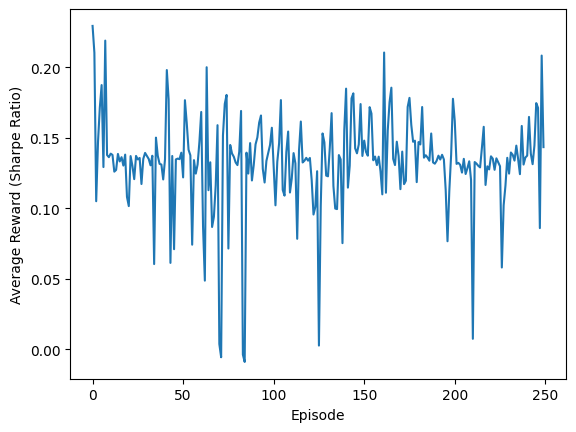

In [33]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward (Sharpe Ratio)")
plt.show()

In [34]:
# Save the final best model after training completes
torch.save(best_actor_state, 'saved_models/best_actor_6-1.pth')
torch.save(best_critic_state, 'saved_models/best_critic_6-1.pth')

# Save the last model
torch.save(agent.actor.state_dict(), "saved_models/last_actor_6-1.pth")
torch.save(agent.critic.state_dict(), "saved_models/last_critic_6-1.pth")